---

## **1. Data Preprocessing**

### Load Data


In [20]:
#%conda install pandas

In [21]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('csv/data_cleaned.csv')
display(data.head())

# Calculate elapsed days
data['EllapsedDays'] = (datetime.now() - pd.to_datetime(data['Date'])).dt.days
display(data.head())

# Drop unnecessary columns
columns_to_drop = ['DATEADDED', 'ActionGeo_FullName', 'ActionGeo_Lat', 'ActionGeo_Long', 'Lag', 'LagCluster', 'Month']
data.drop(columns=columns_to_drop, inplace=True)
display(data.head())


,GlobalEventID,Date,DATEADDED,IsRootEvent,EventCode,EventBaseCode,EventRootCode,GoldsteinScale,NumMentions,AvgTone,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,Lag,LagCluster,Month
0,1218008600,2024-12-29,2024-12-29,1,111,111,11,-2.0,3,6.336634,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12
1,1218059434,2024-12-29,2024-12-29,1,90,90,9,-2.0,10,-6.250000,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12
2,1217968727,2024-12-29,2024-12-29,1,111,111,11,-2.0,4,0.806952,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12
3,1218064446,2024-12-29,2024-12-29,1,90,90,9,-2.0,10,0.884956,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12
4,1218009043,2024-12-29,2024-12-29,1,111,111,11,-2.0,3,6.336634,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12


,GlobalEventID,Date,DATEADDED,IsRootEvent,EventCode,EventBaseCode,EventRootCode,GoldsteinScale,NumMentions,AvgTone,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,Lag,LagCluster,Month,EllapsedDays
0,1218008600,2024-12-29,2024-12-29,1,111,111,11,-2.0,3,6.336634,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,13
1,1218059434,2024-12-29,2024-12-29,1,90,90,9,-2.0,10,-6.250000,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,13
2,1217968727,2024-12-29,2024-12-29,1,111,111,11,-2.0,4,0.806952,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,13
3,1218064446,2024-12-29,2024-12-29,1,90,90,9,-2.0,10,0.884956,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,13
4,1218009043,2024-12-29,2024-12-29,1,111,111,11,-2.0,3,6.336634,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,13


,GlobalEventID,Date,IsRootEvent,EventCode,EventBaseCode,EventRootCode,GoldsteinScale,NumMentions,AvgTone,EllapsedDays
0,1218008600,2024-12-29,1,111,111,11,-2.0,3,6.336634,13
1,1218059434,2024-12-29,1,90,90,9,-2.0,10,-6.250000,13
2,1217968727,2024-12-29,1,111,111,11,-2.0,4,0.806952,13
3,1218064446,2024-12-29,1,90,90,9,-2.0,10,0.884956,13
4,1218009043,2024-12-29,1,111,111,11,-2.0,3,6.336634,13



---

## **2. Data Preparation**

### Prepare Unique Event Codes and Rolling Sequences


In [22]:

# Convert 'Date' to datetime and find min/max dates
data['Date'] = pd.to_datetime(data['Date'])
min_date = data['Date'].min().date()
max_date = datetime.now().date()

print(f"Minimum date in the dataset: {min_date}")
print(f"Maximum date (today): {max_date}")

# Prepare unique event codes
unique_event_base_codes = sorted(data['EventBaseCode'].unique())
base_code_to_index = {code: idx for idx, code in enumerate(unique_event_base_codes)}
print(base_code_to_index)

# Create event count DataFrame
event_count_df = pd.DataFrame(columns=['Date'] + unique_event_base_codes)
event_count_df['Date'] = pd.date_range(start=min_date, end=max_date)

# Fill event counts
for date in event_count_df['Date']:
    day_data = data[data['Date'].dt.date == date.date()]
    for code in unique_event_base_codes:
        event_count_df.loc[event_count_df['Date'] == date, code] = day_data[day_data['EventBaseCode'] == code].shape[0]

# Fill NaN with 0
event_count_df.fillna(0, inplace=True)

# Display prepared DataFrame
display(event_count_df.head())


Minimum date in the dataset: 2020-01-02
Maximum date (today): 2025-01-11
{24: 0, 25: 1, 90: 2, 91: 3, 92: 4, 93: 5, 94: 6, 104: 7, 105: 8, 111: 9, 113: 10, 114: 11, 123: 12, 124: 13, 133: 14, 138: 15, 139: 16, 141: 17, 143: 18, 144: 19, 145: 20, 172: 21, 175: 22, 182: 23, 183: 24}


,Date,24,25,90,91,92,93,94,104,105,...,138,139,141,143,144,145,172,175,182,183
0,2020-01-02,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-05,0,0,6,0,0,0,0,0,0,...,0,0,5,2,0,0,0,0,0,0
4,2020-01-06,0,0,8,0,0,0,0,0,0,...,0,0,7,2,0,0,0,0,1,0


---

### Create TensorFlow Dataset



In [23]:
# Drop the 'Date' column
event_count_df.drop(columns=['Date'], inplace=True)

# Display the updated DataFrame
display(event_count_df.head())

,24,25,90,91,92,93,94,104,105,111,...,138,139,141,143,144,145,172,175,182,183
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,6,0,0,0,0,0,0,3,...,0,0,5,2,0,0,0,0,0,0
4,0,0,8,0,0,0,0,0,0,14,...,0,0,7,2,0,0,0,0,1,0


In [24]:
# Define rolling sequence length
sequence_length = 7

# Extract data and labels
event_data = event_count_df.values.astype('float32')  # All event counts
labels = event_count_df[145].values.astype('float32')  # Predict '145' event counts

# Create TensorFlow datasets
X_dataset = tf.data.Dataset.from_tensor_slices(event_data)
Y_dataset = tf.data.Dataset.from_tensor_slices(labels)

# Create rolling windows
X_sequences = X_dataset.window(sequence_length, shift=1, drop_remainder=True)
X_sequences = X_sequences.flat_map(lambda window: window.batch(sequence_length))
Y_labels = Y_dataset.skip(sequence_length)



In [25]:
# Combine features and labels
dataset = tf.data.Dataset.zip((X_sequences, Y_labels))

In [26]:
# Extract the first sequence and label from the dataset
for x_seq, y_label in dataset.take(1):
	first_x_seq = x_seq
	first_y_label = y_label

# Convert x_seq to a DataFrame
x_df = pd.DataFrame(first_x_seq.numpy(), columns=unique_event_base_codes)
display(x_df)

# Print y_label
print(f"Value of column 145 on the 8th row: {first_y_label.numpy()}")

2025-01-11 07:29:22.473730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,24,25,90,91,92,93,94,104,105,111,...,138,139,141,143,144,145,172,175,182,183
0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,...,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,...,4.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Value of column 145 on the 8th row: 1.0


---

Compared to the following -- the example below is a correct formulation.

---

In [27]:
# Display the first 7 rows of event_count_df
first_7_rows_df = event_count_df.head(7)
display(first_7_rows_df)

# Get the value of column 145 on the 8th row
value_8th_row_col_145 = event_count_df.iloc[7][145]
print(f"Value of column 145 on the 8th row: {value_8th_row_col_145}")

,24,25,90,91,92,93,94,104,105,111,...,138,139,141,143,144,145,172,175,182,183
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,6,0,0,0,0,0,0,3,...,0,0,5,2,0,0,0,0,0,0
4,0,0,8,0,0,0,0,0,0,14,...,0,0,7,2,0,0,0,0,1,0
5,0,0,11,0,0,0,0,0,0,21,...,0,0,3,0,0,0,0,0,0,0
6,0,0,22,0,0,0,0,0,0,12,...,4,0,6,0,1,0,0,0,0,0


Value of column 145 on the 8th row: 1


---

Ok good - the values look accurate!

That's fantastic. 

Let's go ahead and do the test / train split.

---

---

I had some issues with the test / train data set having values that were too high / too low and this threw off the validation and test data error over time, so I could have normalized the error, or I figured it would be more interesting to randomly assign the training and testing data, so that both data sets had equal exposure to ranges of the labels. 

This might be ill advised for LSTM, so I might change this later.

---

In [ ]:
import random
import numpy as np

# Initialize empty lists for train and test datasets
train_data = []
test_data = []

# Iterate through the dataset and randomly assign each element to train or test
for x_seq, y_label in dataset:
	if random.random() < 0.5:
		train_data.append((x_seq.numpy(), y_label.numpy()))
	else:
		test_data.append((x_seq.numpy(), y_label.numpy()))

# Convert lists to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((np.array([x for x, _ in train_data]), np.array([y for _, y in train_data]))).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((np.array([x for x, _ in test_data]), np.array([y for _, y in test_data]))).batch(32).prefetch(tf.data.AUTOTUNE)

2025-01-11 07:33:58.078045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence




---

## **3. Model Building and Training**

### Build LSTM Model


In [32]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, len(unique_event_base_codes))),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Add callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=callbacks
)


/opt/anaconda3/envs/civil_unrest/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        15,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,251 (59.57 KB)

 Trainable params: 15,251 (59.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2025-01-11 07:34:13.078270: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 107.1360 - mae: 2.9434 - val_loss: 22.9750 - val_mae: 1.4595
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 70.7599 - mae: 2.2590 - val_loss: 16.6925 - val_mae: 1.2641
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 49.8983 - mae: 1.9921 - val_loss: 14.4188 - val_mae: 1.2246
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 37.8488 - mae: 1.9143 - val_loss: 20.0259 - val_mae: 1.3875
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 19.6602 - mae: 1.6907 - val_loss: 13.7955 - val_mae: 1.2674
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 18.6874 - mae: 1.5903 - val_loss: 16.8553 - val_mae: 1.3188
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 15.6728 - mae: 1.4817 - val_loss: 17.6402 - val_mae: 1.3075
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 14.3903 - mae: 1.5064 - val_loss: 13.2262 - val_mae: 1.2303
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss



---

## **4. Evaluate and Visualize Results**

### Evaluate Model


In [33]:

# Evaluate the model
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 24.2666 - mae: 1.7193
Test Loss: 12.989356994628906, Test MAE: 1.2115991115570068




### Visualize Training and Predictions


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2025-01-11 07:34:47.803905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


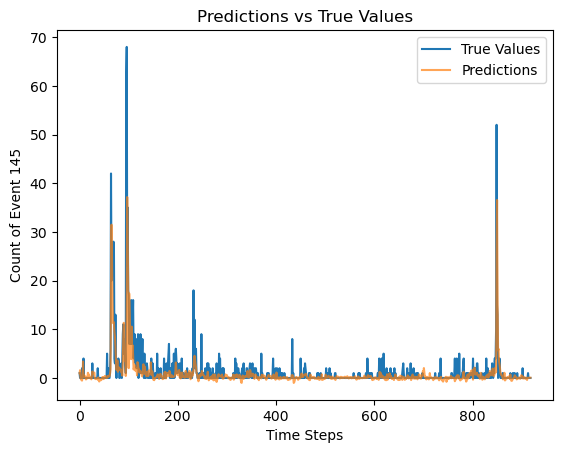

In [34]:
import numpy as np

# Make predictions
predictions = model.predict(test_dataset)

# Visualize predictions vs true values
true_values = np.concatenate([label.numpy() for _, label in test_dataset])
plt.plot(true_values, label='True Values')
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.title('Predictions vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Count of Event 145')
plt.legend()
plt.show()

---

Let's focus more on the DNC protests.

---

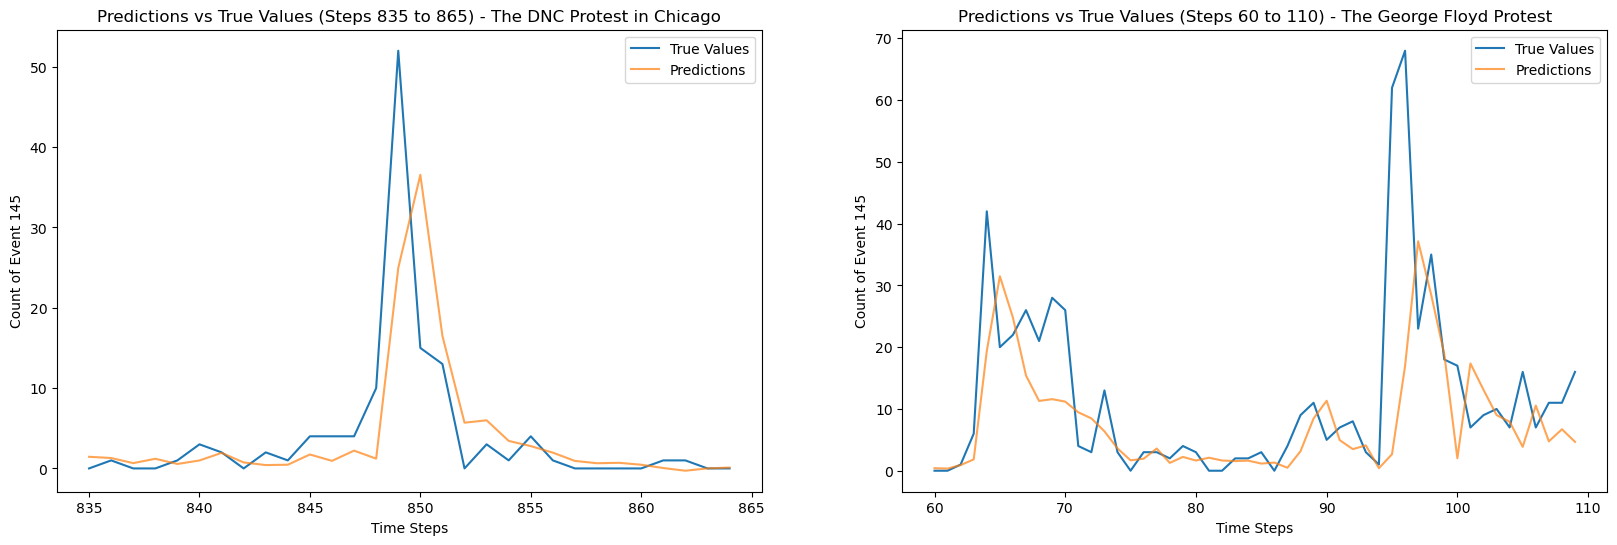

In [54]:
# Define the range for plotting
start_step_dnc = 835
end_step_dnc = 865
start_step_gf = 60
end_step_gf = 110

# Extract the relevant range of true values and predictions for DNC
true_values_range_dnc = true_values[start_step_dnc:end_step_dnc]
predictions_range_dnc = predictions[start_step_dnc:end_step_dnc]

# Extract the relevant range of true values and predictions for George Floyd
true_values_range_gf = true_values[start_step_gf:end_step_gf]
predictions_range_gf = predictions[start_step_gf:end_step_gf]

# Plot the true values and predictions for DNC
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(range(start_step_dnc, end_step_dnc), true_values_range_dnc, label='True Values')
plt.plot(range(start_step_dnc, end_step_dnc), predictions_range_dnc, label='Predictions', alpha=0.7)
plt.title(f'Predictions vs True Values (Steps {start_step_dnc} to {end_step_dnc}) - The DNC Protest in Chicago')
plt.xlabel('Time Steps')
plt.ylabel('Count of Event 145')
plt.legend()

# Plot the true values and predictions for George Floyd
plt.subplot(1, 2, 2)
plt.plot(range(start_step_gf, end_step_gf), true_values_range_gf, label='True Values')
plt.plot(range(start_step_gf, end_step_gf), predictions_range_gf, label='Predictions', alpha=0.7)
plt.title(f'Predictions vs True Values (Steps {start_step_gf} to {end_step_gf}) - The George Floyd Protest')
plt.xlabel('Time Steps')
plt.ylabel('Count of Event 145')
plt.legend()

plt.show()

---

Notice how the model consistantly lags the true values. This is not ideal, but maybe it still has ethicacy.

It seems the spike at step ~65 was proactively predicted, but I'm not sure.

---

---

## **5. Analyze Results**

### Analyze Performance


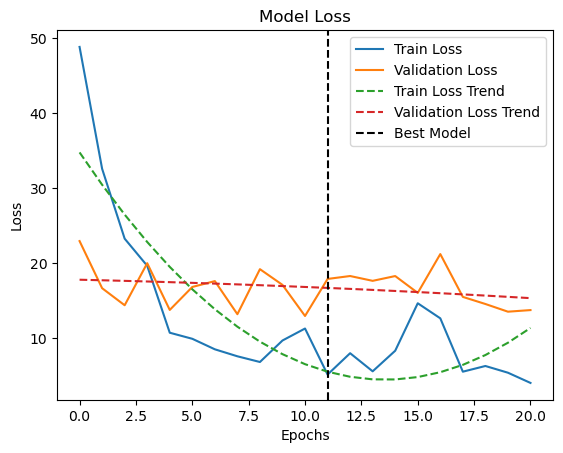

In [44]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Fit parabolic trend curves
epochs = np.arange(len(history.history['loss']))
train_poly = np.poly1d(np.polyfit(epochs, history.history['loss'], 2))
val_poly = np.poly1d(np.polyfit(epochs, history.history['val_loss'], 2))

# Plot parabolic trend curves
plt.plot(epochs, train_poly(epochs), label='Train Loss Trend', linestyle='--')
plt.plot(epochs, val_poly(epochs), label='Validation Loss Trend', linestyle='--')

# Add vertical line for the best model
best_epoch = len(history.history['loss']) - 10
plt.axvline(x=best_epoch, color='black', linestyle='--', label='Best Model')

plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

---

The plot shows that while **training loss** decreases steadily, **validation loss** fluctuates and stabilizes around epoch 10, indicating potential **overfitting**. The model continues to improve on training data, but its performance on unseen data does not. 

The model uses **early stopping with a patience of 10 epochs**, meaning it continues training for 10 additional epochs after finding the best model. As a result, the model with the lowest error is at epoch 10, since the final epoch is 20 (20 - 10 = 10).

---
